In [ ]:
! pip install  kaggle

In [ ]:
from google.colab import files
files.upload()


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"daksh22bai1077","key":"e20958bfd570912094c4344df6972580"}'}

In [ ]:
# Move kaggle.json to ~/.kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# Download and unzip the dataset
!kaggle datasets download -d truthisneverlinear/dentex-challenge-2023 -p /content/dentex_dataset
!unzip -q /content/dentex_dataset/dentex-challenge-2023.zip -d /content/dentex_dataset


Dataset URL: https://www.kaggle.com/datasets/truthisneverlinear/dentex-challenge-2023
License(s): CC0-1.0
100% 10.3G/10.3G [07:37<00:00, 24.9MB/s]
100% 10.3G/10.3G [07:37<00:00, 24.2MB/s]


In [ ]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch [1/10], Training Loss: 0.0252
Epoch [1/10], Validation Loss: 0.0000
Epoch [2/10], Training Loss: 0.0000
Epoch [2/10], Validation Loss: 0.0000
Epoch [3/10], Training Loss: 0.0000
Epoch [3/10], Validation Loss: 0.0000
Epoch [4/10], Training Loss: 0.0000
Epoch [4/10], Validation Loss: 0.0000
Epoch [5/10], Training Loss: 0.0000
Epoch [5/10], Validation Loss: 0.0000
Epoch [6/10], Training Loss: 0.0000
Epoch [6/10], Validation Loss: 0.0000
Epoch [7/10], Training Loss: 0.0000
Epoch [7/10], Validation Loss: 0.0000
Epoch [8/10], Training Loss: 0.0000
Epoch [8/10], Validation Loss: 0.0000
Epoch [9/10], Training Loss: 0.0000
Epoch [9/10], Validation Loss: 0.0000
Epoch [10/10], Training Loss: 0.0000
Epoch [10/10], Validation Loss: 0.0000


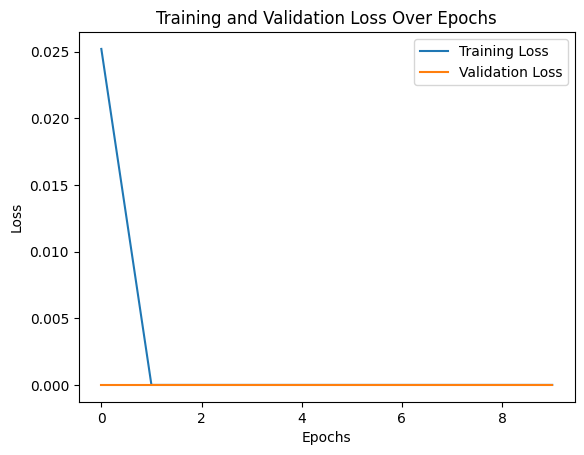

In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import default_collate

# Custom dataset class
class DentalDataset(Dataset):
    def __init__(self, data_dir, json_file, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        with open(json_file, 'r') as f:
            self.data = json.load(f)
        self.images = self.data['images']

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.data_dir, img_info['file_name'])
        image = Image.open(img_path).convert("RGB")

        # Here you should define how to get your labels
        # This is a placeholder for labels; replace with your actual logic
        labels = self.get_labels(img_info['id'])  # Implement this method

        if labels is None:  # Handle invalid labels
            return None

        if self.transform:
            image = self.transform(image)

        return image, labels

    def get_labels(self, img_id):
        # Replace this with your logic to get labels based on img_id
        # For example, you might return [quadrant_label, tooth_label, diagnosis_label]
        # If invalid, return None
        # This is just a placeholder for illustration
        return [0, 1, 2]  # Replace with actual labels

# Custom collate function to handle None values
def custom_collate(batch):
    # Filter out None samples
    batch = [item for item in batch if item is not None]

    if len(batch) == 0:
        return None  # If the batch is empty after filtering, return None

    # Use default collate for the remaining items
    return default_collate(batch)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create dataset and dataloaders
data_dir = '/content/dentex_dataset/training_data/training_data/quadrant-enumeration-disease/xrays'  # Adjust path
json_file = '/content/dentex_dataset/training_data/training_data/quadrant-enumeration-disease/train_quadrant_enumeration.json'  # Adjust path
train_dataset = DentalDataset(data_dir, json_file, transform=transform)
val_dataset = DentalDataset(data_dir, json_file, transform=transform)  # Use separate validation data

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=custom_collate  # Use the custom collate function
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=custom_collate  # Use the custom collate function
)

# Define the model (Replace with your actual model)
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.resnet = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(16 * 112 * 112, 3)  # Adjust the output size based on your labels
        )

    def forward(self, x):
        return self.resnet(x)

# Training function
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            if batch is None:  # Skip any None batches
                continue

            images, labels = batch
            images = images.to(device)
            quadrant_labels = labels[0].to(device)  # Adjust for your label structure

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, quadrant_labels)  # Adjust for your loss calculations

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))
        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_losses[-1]:.4f}")

        # Evaluate model on validation set
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                if batch is None:  # Skip any None batches
                    continue

                images, labels = batch
                quadrant_labels = labels[0].to(device)  # Adjust for your label structure

                outputs = model(images)
                val_loss += criterion(outputs, quadrant_labels).item()  # Adjust for your loss calculations

        val_losses.append(val_loss / len(val_loader))
        print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_losses[-1]:.4f}")

    # Plot training and validation loss
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, criterion, and optimizer
model = SimpleModel().to(device)
criterion = nn.CrossEntropyLoss()  # Adjust this based on your needs
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Run training
num_epochs = 10  # Set the number of epochs
train(model, train_loader, val_loader, criterion, optimizer, num_epochs)
